In [1]:
import os
import warnings
import os.path
import pandas as pd
import torch
import ttach as tta
from models import *
import pytorch_lightning as pl
from torch.nn import functional as F
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from sklearn import metrics
from config import *
from util import *
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
rc = {"figure.figsize" : (9, 7),
      "axes.spines.left" : False,
      "axes.spines.right" : False,
      "axes.spines.bottom" : False,
      "axes.spines.top" : False,
      "xtick.bottom" : True,
      "xtick.labelbottom" : True,
      "ytick.labelleft" : True,
      "ytick.left" : True,
      "axes.grid" : False}
plt.rcParams.update(rc)

/home/caduser/anaconda3/envs/overlap/lib/python3.9/site-packages/neptune/internal/backends/hosted_client.py:50: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  from neptune.version import version as neptune_client_version
/home/caduser/anaconda3/envs/overlap/lib/python3.9/site-packages/pytorch_lightning/loggers/neptune.py:41: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  from neptune import new as neptune


In [2]:
torch.cuda.empty_cache()

# Define model object and trainer.
model = MelanomaClassifier(data_dir=data_dir, weighted_sampling=True, batch_size=batch_size, learning_rate=learning_rate)
trainer = pl.Trainer(max_epochs=num_epochs, devices=1, accelerator="gpu", deterministic=True)

trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Missing logger folder: /home/caduser/Tirtha/reproduce/baseline/lightning_logs

  | Name        | Type        | Params
--------------------------------------------
0 | loss        | BCELoss     | 0     
1 | base_model  | ResNet      | 23.5 M
2 | sigm        | Sigmoid     | 0     
3 | accuracy    | Accuracy    | 0     
4 | auroc       | AUROC       | 0     
5 | sensitivity | Recall      | 0     
6 | specificity | Specificity | 0     
--------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.040    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [3]:
print('Val:')
result = get_dx_predictions(trainer, model, split='val', threshold=0.5)
threshold = find_optimal_cutoff(result['true'], result['score'])
display_scores(result)
print('Test:')
result = get_dx_predictions(trainer, model, split='test', threshold=threshold)
display_scores(result)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Val:


Predicting: 84it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


=====
AUC: 0.859493670886076
Balanced Acc: 0.7942670002943775
Sensitivity: 0.7151162790697675
Specificity: 0.8734177215189873
=====

Test:


Predicting: 84it [00:00, ?it/s]

=====
AUC: 0.8773000000000001
Balanced Acc: 0.8049999999999999
Sensitivity: 0.79
Specificity: 0.82
=====



# Transparency Quantification

In [4]:
result = pd.concat([model.test_set.metadata[["image_id", "lesion_id", "benign_malignant"]].reset_index(drop=True),
                        result.reset_index(drop=True)], axis=1)
masks = pd.read_csv("/home/caduser/Tirtha/overlap/data/metadata_testset.csv")
masks_dict = dict(zip(masks['image_id'], masks['mask']))
result['mask'] = result['image_id'].apply(lambda x: str(masks_dict[x]))
result.rename({'pred': 'prediction'}, axis=1, inplace=True)
result.head()

,image_id,lesion_id,benign_malignant,score,prediction,true,mask
0,ISIC_0025451,HAM_0002143,1,0.576164,1,1.0,1418
1,ISIC_0030486,HAM_0001150,1,0.999805,1,1.0,1558
2,ISIC_0028361,HAM_0001747,1,1.000000,1,1.0,8398
3,ISIC_0030080,HAM_0006900,1,0.998709,1,1.0,7534
4,ISIC_0027174,HAM_0007390,1,0.906594,1,1.0,7115


In [5]:
%%time

def forward(img):
    output = model(img)
    if output.item() >= 0.5:
        attributions = layer_gc.attribute(img, 0, relu_attributions=True)
    else:
        attributions = layer_gc.attribute(img, 0, relu_attributions=False)
        attributions = torch.relu(attributions*-1)
    attributions = F.interpolate(attributions, size=(224, 224), mode='bilinear')
    return output, attributions


mode = 'blacken'
#mode = 'randomize'

output_scores_dict = {}
attributions_dict = {}
layer_gc = LayerGradCam(model.base_model, model.base_model.layer4[-1])
img_dir = "/home/caduser/Tirtha/overlap/data/HAM10000/HAM10000"
annotations_dir = "/home/caduser/Tirtha/overlap/data/ground_truth/annotations_gt"
metadata_file = "/home/caduser/Tirtha/overlap/data/ground_truth/metadata_gt.csv"
fidelity_dict = {}
for percentile in range(5, 100, 5):
    for idx, row in result.iterrows():
        # Read the image
        raw_img = io.imread(os.path.join(img_dir, row.image_id+'.jpg'))
        # Transform the image (resize, normalize) and get prediction and attributions
        img = model.test_transform(image=raw_img, mask=raw_img)['image'].unsqueeze(0)
        output, attributions = forward(img)

        # Change the shapes of the attributions and logits tensors
        attributions = attributions.squeeze(0).detach().numpy()
        output = output.squeeze(0).item()


        attributions_dict[row.image_id] = (output, attributions)

        attr_non_zero = attributions[attributions>0.]
        if len(attr_non_zero) == 0:
            perc = 0
        else:
            perc = (np.percentile(attr_non_zero, percentile))
        attr = (attributions >= perc).copy()


        attr[attr > 0] = 1
        # Flip the pixels so that the non important areas are 1s and important areas are 0s
        #attr = attr.astype(int) ^ np.ones_like(attr.astype(int))
        attr = attr[np.newaxis, ...]

        new_img = img.clone()

        if mode == 'randomize':

            shape = img[0,0,:,:][attr[0]==1].shape[0]
            for i in range(3):
                new_img[0,i,:,:][attr[0]==1] = torch.tensor(np.random.choice(img.flatten(), size=shape)).float()

        elif mode == 'blacken':
            shape = img[0,0,:,:][attr[0]==1].shape[0]   
            for i in range(3):
                new_img[0,i,:,:][attr[0]==1] = 0

        # Occlude the img and set to new_img
        #new_img = (img * attr).to(torch.float32).detach()


        new_output, new_attributions = forward(new_img)

        new_attributions = new_attributions.squeeze(0).detach().numpy()
        new_output = new_output.squeeze(0).item()

        output_scores_dict[row.image_id] = [output, new_output]        

        #print(row.image_id)
        #break

    output_changes_dict = {}
    for key, val in output_scores_dict.items():
        try:
            output_changes_dict[key] = np.abs(val[0] - val[1])
        except:
            pass
    fidelity = np.array(list(output_changes_dict.values()))
    fidelity_dict[percentile] = fidelity

CPU times: user 4h 35min 16s, sys: 3min 27s, total: 4h 38min 43s
Wall time: 8min 42s


In [6]:
dfs = []
for percentile in fidelity_dict.keys():
    df = pd.DataFrame(fidelity_dict[percentile], columns=['Fidelity'])
    df['Threshold'] = percentile
    dfs.append(df)
fidelity_df = pd.concat(dfs)

In [9]:
fidelity_df.to_csv('../data/baseline/fidelity.csv', index=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


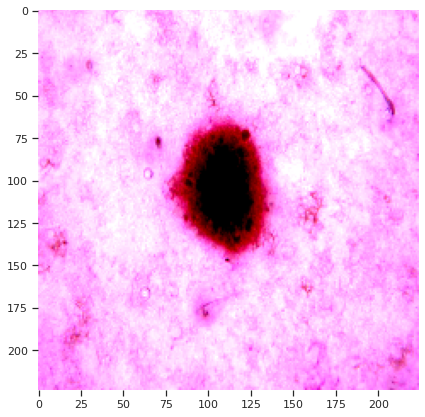

In [7]:
plt.imshow(torch.permute(img[0], (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


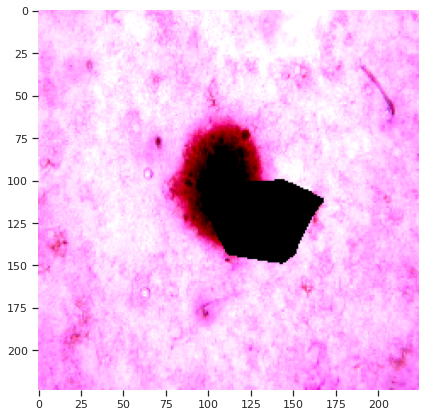

In [8]:
plt.imshow(np.transpose(new_img[0], (1, 2, 0)))